## Load and Preprocess

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from   timeit import default_timer as timer

In [2]:
train_full = pd.read_csv("./MNIST Dataset/sign_mnist_train.csv")
test       = pd.read_csv("./MNIST Dataset/sign_mnist_test.csv")

In [48]:
label_map = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
np.save("./labels.npy", label_map)

In [4]:
X_train_full = train_full.values[:,1:].astype(np.float32())
y_train_full = train_full.values[:,0]
X_test = test.values[:,1:].astype(np.float32())
y_test = test.values[:,0]

In [5]:
# splitting validation set from the training set using stratified splitting
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 2500)
for train_index, test_index in split.split(X_train_full, y_train_full):
    X_train, X_val = X_train_full[train_index], X_train_full[test_index]
    y_train, y_val = y_train_full[train_index], y_train_full[test_index]

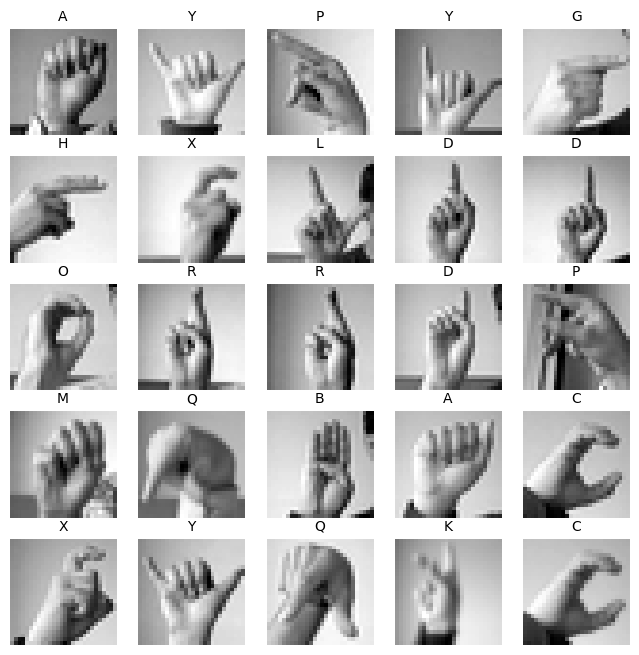

In [6]:
# visualizing random images from the training set
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (8, 8))
train_len = X_train.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(train_len)
    ax.set_title(label_map[y_train[idx]], size = 10)
    ax.axis("off")
    ax.imshow(X_train[idx].reshape((28, 28)), cmap = "gray")

In [7]:
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

## Classic Machine Learning Models

In [8]:
from sklearn.metrics import accuracy_score

models_data = {}

def model_fit_and_print_acc(model):
    start_train = timer()
    model.fit(X_train, y_train)
    end_train = timer()
    start_pred = timer()
    train_pred = model.predict(X_train)
    end_pred = timer()
    train_acc = accuracy_score(train_pred, y_train)
    print("Train accuracy: ", train_acc)
    test_pred = model.predict(X_test)
    test_acc = accuracy_score(test_pred, y_test)
    print("Test accuracy: ", test_acc)
    return [end_train-start_train, end_pred-start_pred, train_acc, test_acc]

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 10000)
#models_data["Logistic Regression"] = model_fit_and_print_acc(log_reg)

In [10]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
#models_data["Random Forest"] = model_fit_and_print_acc(forest_clf)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5)
#models_data["KNN"] = model_fit_and_print_acc(knn)

## CNN

In [12]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 7))

    ax1.plot(history["loss"], label = "Train loss")
    ax1.plot(history["val_loss"], label = "Validation loss")
    ax2.plot(history["accuracy"], label = "Train accuracy")
    ax2.plot(history["val_accuracy"], label = "Validation accuracy")

    ax1.legend(fontsize = 15)
    ax2.legend(fontsize = 15)

    ax1.set_title("Loss per epoch", fontsize = 25)
    ax1.set_xlabel("epoch", fontsize = 20)
    ax2.set_title("Accuracy per epoch", fontsize = 25)
    ax2.set_xlabel("epoch", fontsize = 20)

    ax1.grid(True)
    ax2.grid(True)

In [13]:
X_train     = np.array([X_train]).reshape((X_train.shape[0], 28, 28, 1))
X_val       = np.array([X_val])  .reshape((X_val.shape[0], 28, 28, 1))
X_test      = np.array([X_test]) .reshape((X_test.shape[0], 28, 28, 1))
image_shape = X_train[0].shape
print(image_shape)

(28, 28, 1)


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = image_shape),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.15),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.Conv2D(8, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(8, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Conv2D(16, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(16, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Conv2D(32, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(len(label_map), activation = "softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation (RandomT  (None, 28, 28, 1)        0         
 ranslation)                                                     
                                                                 
 random_zoom (RandomZoom)    (None, 28, 28, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 28, 28, 1)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                        

In [15]:
# Builds the model
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = image_shape),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.15),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.Conv2D(8, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(8, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Conv2D(16, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(16, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Conv2D(32, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2D(32, kernel_size = (3, 3), strides = 1, padding = "same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2, padding = "valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(len(label_map), activation = "softmax")
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_translation_1 (Rando  (None, 28, 28, 1)        0         
 mTranslation)                                                   
                                                                 
 random_zoom_1 (RandomZoom)  (None, 28, 28, 1)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 28, 28, 1)        0         
 tation)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 8)        32        
 hNormalization)                                                 
                                                      

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [38]:
# Defines the optimizer
customOptimizer = tf.keras.optimizers.Adam(5e-4)

# Defines the loss function
customLoss      = tf.keras.losses.SparseCategoricalCrossentropy()

# Defines the callbacks to include
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath = "./MNIST Models/Accuracy/mnist_detection.acc.{epoch:02d}-{val_accuracy:.2f}.h5", monitor = "val_accuracy", mode = "max", save_best_only = True),
    tf.keras.callbacks.ModelCheckpoint(filepath = "./MNIST Models/Loss/mnist_detection.loss.{epoch:02d}-{val_loss:.2f}.h5", monitor = "val_loss", mode = "min", save_best_only = True),
    tf.keras.callbacks.EarlyStopping  (patience = 200, monitor = "accuracy"),
    tf.keras.callbacks.TensorBoard    (log_dir  = "./Logs")
]

# Compile the model
model.compile(optimizer = customOptimizer, loss = customLoss, metrics = ["accuracy"], jit_compile = None)

In [39]:
start_train = timer()
history     = model.fit(X_train, y_train, epochs = 5000, batch_size = 16, validation_data = (X_val, y_val), callbacks = my_callbacks, use_multiprocessing = True)
end_train   = timer()

Epoch 1/10
1560/1560 [==============================] - 34s 18ms/step - loss: 0.0245 - accuracy: 0.9941 - val_loss: 0.0293 - val_accuracy: 0.9964
Epoch 2/10
1560/1560 [==============================] - 28s 18ms/step - loss: 0.0235 - accuracy: 0.9939 - val_loss: 0.0067 - val_accuracy: 0.9988
Epoch 3/10
1560/1560 [==============================] - 28s 18ms/step - loss: 0.0252 - accuracy: 0.9934 - val_loss: 0.0174 - val_accuracy: 0.9956
Epoch 4/10
1560/1560 [==============================] - 29s 18ms/step - loss: 0.0227 - accuracy: 0.9941 - val_loss: 0.0386 - val_accuracy: 0.9932
Epoch 5/10
1560/1560 [==============================] - 29s 18ms/step - loss: 0.0262 - accuracy: 0.9936 - val_loss: 0.0173 - val_accuracy: 0.9956
Epoch 6/10
1560/1560 [==============================] - 29s 19ms/step - loss: 0.0203 - accuracy: 0.9942 - val_loss: 0.0133 - val_accuracy: 0.9964
Epoch 7/10
1560/1560 [==============================] - 28s 18ms/step - loss: 0.0223 - accuracy: 0.9939 - val_loss: 0.0279 -

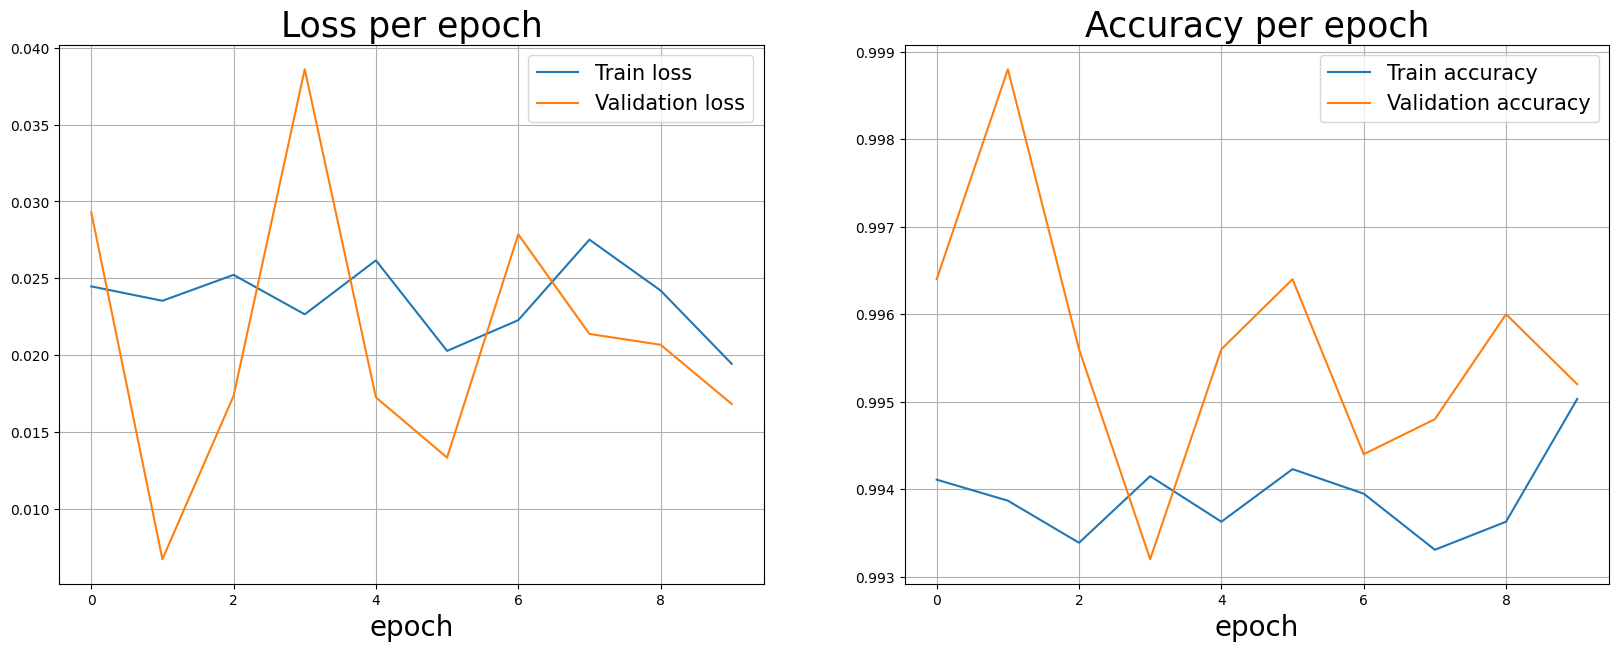

In [40]:
# plot learning Curves
plot_results(history.history)

## CNN Evaluation

In [41]:
# CNN evaluation
start_pred = timer()
train_acc  = model.evaluate(X_train, y_train)[1]
end_pred   = timer()
test_acc   = model.evaluate(X_test, y_test)[1]
models_data["CNN"] = [end_train - start_train, end_pred - start_pred, train_acc, test_acc]

225/225 [==============================] - 1s 6ms/step - loss: 0.0974 - accuracy: 0.9862


In [43]:
test_pred = np.argmax(model.predict(X_test), axis = 1)

225/225 [==============================] - 1s 6ms/step


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: ", precision_score(y_test, test_pred, average = "micro").round(2))
print("Recall: "   , recall_score   (y_test, test_pred, average = "micro").round(2))
print("F1 Score: " , f1_score       (y_test, test_pred, average = "micro").round(2))

Precision:  0.99
Recall:  0.99
F1 Score:  0.99


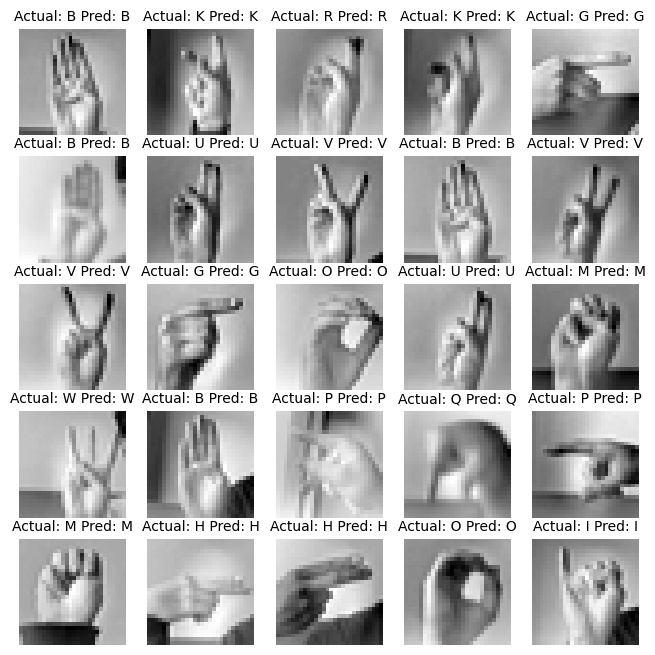

In [45]:
# visualizing predictions of random images from the test set
fig, axs = plt.subplots(nrows = 5, ncols = 5, figsize = (8, 8))
test_len = X_test.shape[0]

for ax in axs.reshape(-1):
    idx = np.random.randint(test_len)
    pred = test_pred[idx]
    ax.set_title("Actual: " + label_map[y_test[idx]] + " Pred: " + label_map[pred], size = 10)
    ax.axis("off")
    ax.imshow(X_test[idx], cmap="gray")

## Model Comparison

Text(0.5, 1.0, 'Models comparison on Accuracy')

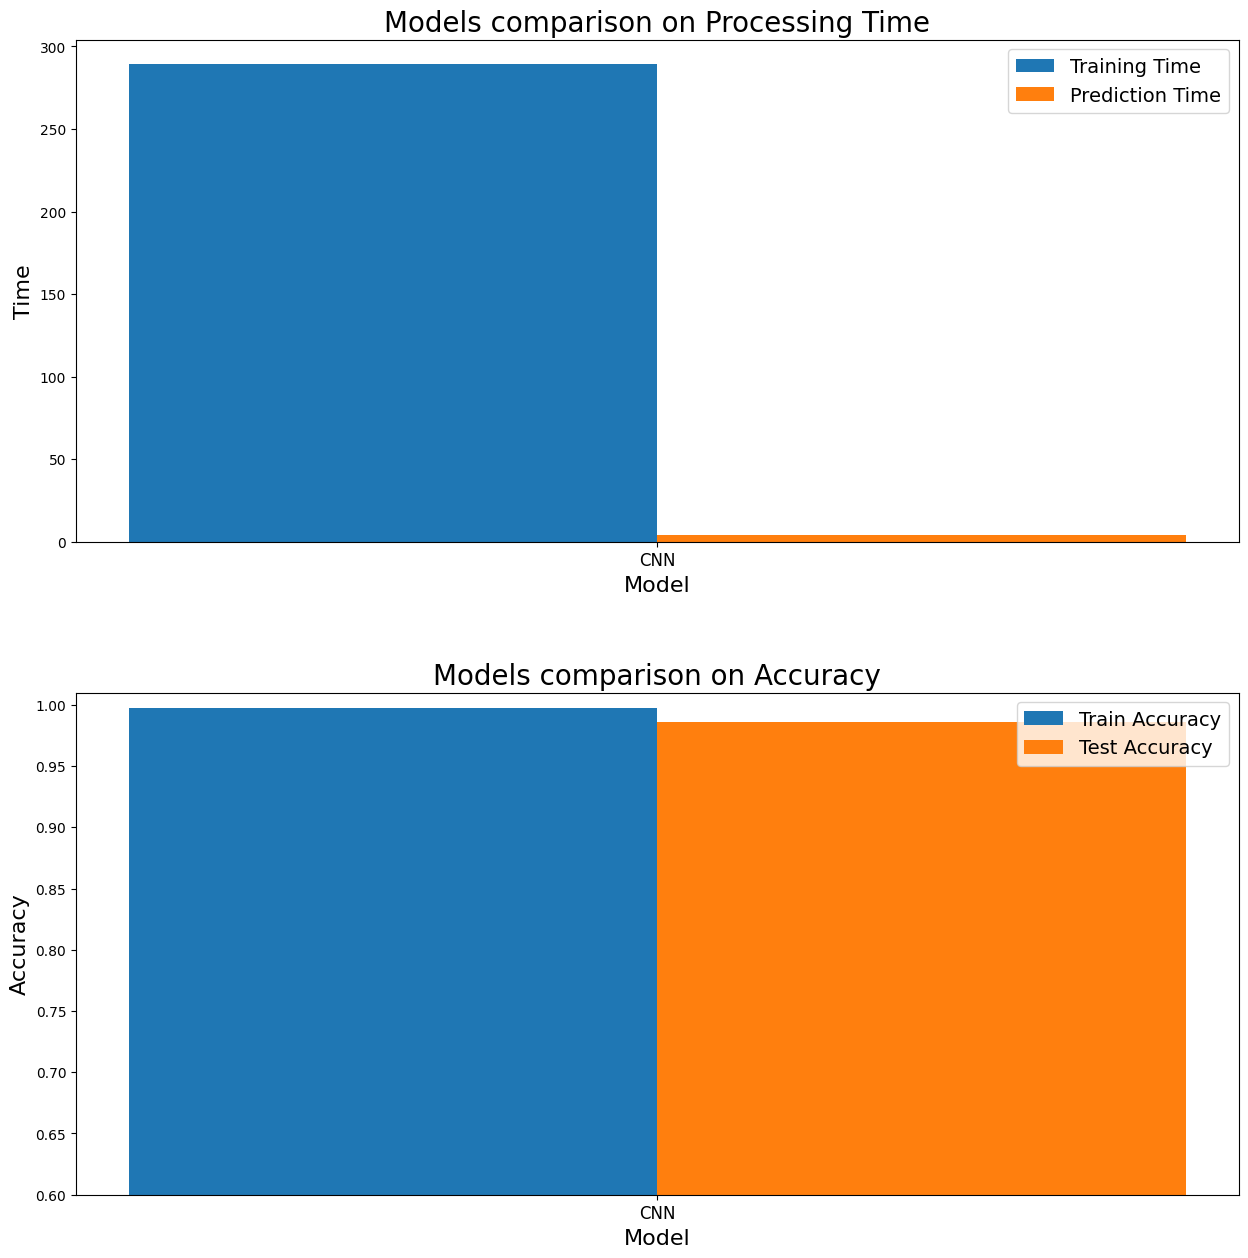

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 15))
fig.subplots_adjust(hspace = 0.3)

X = models_data.keys()
X_axis = np.arange(len(X))

ax1.bar(X_axis - 0.1, [value[0] for value in models_data.values()], 0.2, label = "Training Time")
ax1.bar(X_axis + 0.1, [value[1] for value in models_data.values()], 0.2, label = "Prediction Time")
ax1.set_xticks(X_axis, X, fontsize=12)
ax1.legend(fontsize=14)
ax1.set_xlabel("Model", fontsize=16)
ax1.set_ylabel("Time", fontsize=16)
ax1.set_title("Models comparison on Processing Time", fontsize = 20)

ax2.bar(X_axis - 0.1, [value[2] for value in models_data.values()], 0.2, label = "Train Accuracy")
ax2.bar(X_axis + 0.1, [value[3] for value in models_data.values()], 0.2, label = "Test Accuracy")
ax2.set_xticks(X_axis, X, fontsize = 12)
ax2.legend(fontsize = 14)
ax2.set_xlabel("Model"   , fontsize = 16)
ax2.set_ylabel("Accuracy", fontsize = 16)
ax2.set_ylim((0.6, 1.01))
ax2.set_title("Models comparison on Accuracy", fontsize = 20)